##Importing necessary library

DBN (Deep Belief Network) is a type of deep learning neural network that is composed of multiple layers of Restricted Boltzmann Machines (RBMs) stacked on top of each other. DBNs are trained using unsupervised learning, where the first layer of RBMs learn the features in the input data, then each subsequent RBM layer learns more complex features based on the activations from the previous layer.

RBM (Restricted Boltzmann Machine) is a generative stochastic artificial neural network that can learn a probability distribution over its inputs. RBMs have two layers: a visible layer and a hidden layer, and they use a form of probabilistic learning called contrastive divergence to adjust their weights. RBMs are often used as building blocks for deep learning models, such as DBNs and Deep Boltzmann Machines (DBMs)

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(linewidth=120)
from DBN import DBN

GPUs are better suited for training machine learning models than CPUs because they have parallel processing capabilities, high memory capacity, and more cores, allowing for faster model training. Additionally, using GPUs is cost-effective compared to using multiple CPUs as a single high-end GPU can perform the same amount of work as multiple CPUs at a lower cost. To summarize, GPUs are more efficient and cost-effective for training machine learning models compared to CPUs.

In [ ]:
#check if a GPU is available, If a GPU is available the model will be trained on the GPU 
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


##loading data and Visualizing

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle Boot. The dataset serves as a more challenging replacement for the MNIST dataset, which is widely used as a beginner's dataset for machine learning and computer vision algorithms.

In [ ]:
%%capture
FashionMNIST_train = tv.datasets.FashionMNIST('data/', train=True, download=True,
                                         transform=tv.transforms.Compose(
                                                  [tv.transforms.ToTensor()]
                                         ))

FashionMNIST_test = tv.datasets.FashionMNIST("data/",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

In [ ]:
#converting our dataset to numpy array

X_train = FashionMNIST_train.data.numpy()
X_test = FashionMNIST_test.data.numpy()
y_train = FashionMNIST_train.targets.numpy()
y_test = FashionMNIST_test.targets.numpy()


X_train.shape, y_train, X_test.shape, y_test

((60000, 28, 28),
 array([9, 0, 0, ..., 3, 0, 5]),
 (10000, 28, 28),
 array([9, 2, 1, ..., 8, 1, 5]))

The histogram provides a visual representation of the distribution of the values in the data, which can help to identify patterns and outliers. By visualizing the data in this way, the user can gain a better understanding of the data and make informed decisions about preprocessing or normalization steps.

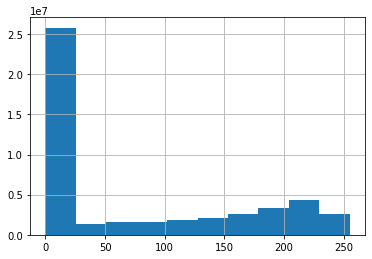

In [ ]:
data = pd.Series(X_train.ravel())
data.hist()

MinMaxScaler is a feature scaling method used in machine learning to normalize the features of a dataset to a specific range, usually between 0 and 1. The method scales the features of the dataset by transforming them so that the resulting values fall within the specified range. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

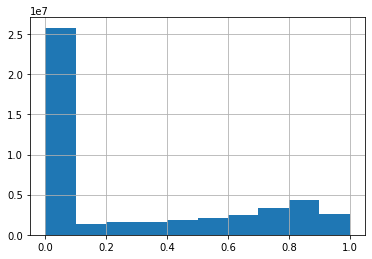

In [ ]:
data = pd.Series(X_train.ravel())
data.hist()

Text(0.5, 1.0, '(Label: Coat)')

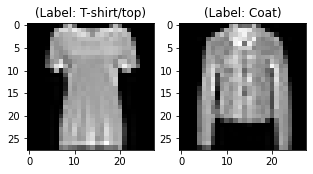

In [ ]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train[10], (28,28))
curr_lbl = y_train[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(labeldict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test[10], (28,28))
curr_lbl = y_test[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(labeldict[curr_lbl]) + ")")

##training DBN

The training of a Deep Belief Network (DBN) consists of two stages: pre-training and fine-tuning.

Pre-training: This stage involves training each layer of the DBN using unsupervised learning with Restricted Boltzmann Machines (RBMs). RBMs are shallow generative models that learn to reconstruct the input data. During pre-training, each RBM learns to extract features from the input data and build a hierarchical representation of the data. This is done layer-by-layer, starting from the input layer and moving towards the deeper layers.

Fine-tuning: After pre-training, the weights learned by the network are used as the initial weights for the fine-tuning stage, where the network is trained using supervised learning on a labeled dataset to perform a specific task. The network adjusts its weights to minimize the error between the predicted output and the true output.

The goal of the DBN is to reduce the amount of supervised training needed and improve the performance of the network by leveraging the unsupervised pre-training stage to learn a good representation of the data. The pre-training stage allows the network to learn a hierarchical representation of the data, which is then used to initialize the network for the fine-tuning stage, making the overall training process more efficient and effective.





In [ ]:
#conveting numpy array to tourch
FashionMNIST_train.data = torch.from_numpy(X_train.reshape(60000, 28, 28))
FashionMNIST_test.data = torch.from_numpy(X_test.reshape(10000, 28, 28))
FashionMNIST_train.targets = torch.from_numpy(y_train)
FashionMNIST_test.targets = torch.from_numpy(y_test)

In [ ]:
dbn_FashionMNIST= DBN(visible_units=28*28,
                hidden_units=[200, 200, 800],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [ ]:
num_epochs = 100
batch_size = 128

dbn_FashionMNIST.train_static(
    FashionMNIST_train.data,
    FashionMNIST_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.0669     |0.0907       |230.3772   |4.8061     |
|20    |1.9634     |0.0924       |213.4353   |4.7841     |
|30    |1.9307     |0.0887       |207.2806   |4.9724     |
|40    |1.9165     |0.0887       |203.8678   |4.3138     |
|50    |1.9061     |0.0877       |203.1244   |3.9782     |
|60    |1.9009     |0.0888       |203.5195   |4.5365     |
|70    |1.8953     |0.0862       |201.3572   |4.5782     |
|80    |1.8913     |0.0849       |199.8565   |3.9312     |
|90    |1.8875     |0.0866       |199.0006   |3.5394     |
|100    |1.8859     |0.0877       |199.2619   |3.5386     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.8818     |0.0687       |58.8516   |1.6148     |
|20    |1.7797     |0.0609       |56.5391   |1.6114     |
|30    |1.7434     |0.0609       |55.3363   |1.2132     |
|40    |1.7286     |0.0617       |5

## Linear read-out

A linear readout of the representations computed by a Deep Belief Network (DBN) at each layer refers to using the activations of each layer as input features for a linear classifier, such as a logistic regression model. The activations at each layer can be thought of as a set of features that represent the input data, and the linear readout uses these features to make predictions.

In a DBN, each layer of the network learns a more abstract representation of the data compared to the previous layer. By using the activations at each layer as input features, the linear readout can take advantage of the hierarchical representation learned by the network, using a combination of low-level and high-level features to make predictions.

The linear readout can be trained using supervised learning on a labeled dataset, adjusting its weights to minimize the error between the predicted output and the true output. The overall goal of the linear readout is to use the representations computed by the DBN to make predictions for a specific task, leveraging the hierarchical representation learned by the network to improve the performance of the classifier.

The code first trains the RBM layers by using the input image data and passes the hidden representation at each layer to the next RBM layer. Then, the linear model is trained with the hidden representations obtained from each of the RBM layers. Finally, the accuracy of the predictions from the trained linear models is calculated by comparing them with the actual labels in the test set.

In [ ]:
#returns the representation of the input data at the kth layer of a Deep Belief Network (DBN)
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_FashionMNIST.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(FashionMNIST_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, last_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(last_layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [ ]:
#specifies the number of units in the input layer.

layer_size = dbn_FashionMNIST.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_FashionMNIST.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_FashionMNIST.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

The code makes use of PyTorch library for deep learning, which provides built-in functions for training and evaluating models. The optimizer used for training is stochastic gradient descent (SGD), and the loss function used is cross-entropy loss. The implementation uses the GPU for acceleration if available.

 SGD is an optimization algorithm that is commonly used in deep learning models for updating the model parameters based on the gradient of the loss function with respect to the parameters. In the code, the SGD optimizer is created with a learning rate of 0.05, and is used to optimize the parameters of the linear models in each iteration of the training loop.


Cross-entropy loss, also known as log loss, measures the dissimilarity between two probability distributions. It is widely used in machine learning, particularly in the training of classification models. The formula for cross-entropy loss is given as:

L = -∑ (t_i * log(y_i))

where t_i is the true label (i.e. ground truth) and y_i is the predicted probability of the correct label. The cross-entropy loss measures the "distance" between the true label and predicted probabilities, with a lower value indicating that the predicted probabilities are closer to the true label.




In [ ]:
def train(network, input, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = FashionMNIST_train.targets.reshape(predictions.shape[0]).to(device)  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train(linear1, hidden_repr_layer_1)
train(linear2, hidden_repr_layer_2)
train(linear3, hidden_repr_layer_3)

epoch :   1/1500, loss = 2.4039
epoch : 101/1500, loss = 0.9733
epoch : 201/1500, loss = 0.7561
epoch : 301/1500, loss = 0.6700
epoch : 401/1500, loss = 0.6218
epoch : 501/1500, loss = 0.5899
epoch : 601/1500, loss = 0.5666
epoch : 701/1500, loss = 0.5486
epoch : 801/1500, loss = 0.5342
epoch : 901/1500, loss = 0.5222
epoch : 1001/1500, loss = 0.5121
epoch : 1101/1500, loss = 0.5034
epoch : 1201/1500, loss = 0.4958
epoch : 1301/1500, loss = 0.4890
epoch : 1401/1500, loss = 0.4831
epoch :   1/1500, loss = 2.3507
epoch : 101/1500, loss = 0.8485
epoch : 201/1500, loss = 0.6882
epoch : 301/1500, loss = 0.6241
epoch : 401/1500, loss = 0.5867
epoch : 501/1500, loss = 0.5611
epoch : 601/1500, loss = 0.5420
epoch : 701/1500, loss = 0.5271
epoch : 801/1500, loss = 0.5150
epoch : 901/1500, loss = 0.5050
epoch : 1001/1500, loss = 0.4965
epoch : 1101/1500, loss = 0.4892
epoch : 1201/1500, loss = 0.4828
epoch : 1301/1500, loss = 0.4772
epoch : 1401/1500, loss = 0.4722
epoch :   1/1500, loss = 2.282

In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(FashionMNIST_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [ ]:
# here we compute the predictions
predictions_test1 = linear1(hidden_repr_layer_1_test)
predictions_test2 = linear2(hidden_repr_layer_2_test)
predictions_test3 = linear3(hidden_repr_layer_3_test)

In [ ]:
#computes the accuracy of predictions
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
compute_accuracy(predictions_test1, FashionMNIST_test.targets.to(device))

0.8252999782562256

In [ ]:
compute_accuracy(predictions_test2, FashionMNIST_test.targets.to(device))

0.8269000053405762

In [ ]:
compute_accuracy(predictions_test3, FashionMNIST_test.targets.to(device))

0.8296999931335449

##Comparison with a feed-forward model


A Feedforward Neural Network (FFNN) model is a type of artificial neural network that is organized in layers and moves data in a forward direction, from input layer to output layer, without looping back. The mathematical formulation of an FFNN can be represented as follows:

Given an input vector X of size (n x 1), where n is the number of features, the output of each layer l can be represented as:

Z_l = W_l * A_{l-1} + b_l

Where W_l is the weight matrix of size (m_l x m_{l-1}), b_l is the bias vector of size (m_l x 1), A_{l-1} is the activation matrix of size (m_{l-1} x 1), m_l is the number of neurons in layer l, and * represents the dot product.

The activation matrix A_l is then obtained by applying an activation function f_l to the result Z_l:

A_l = f_l(Z_l)

Common activation functions include the sigmoid function, hyperbolic tangent, and Rectified Linear Unit (ReLU).

Once the output of the last layer is obtained, the prediction Y_hat is made by taking the dot product of the final activation matrix A_L with another weight matrix W_{L+1} and adding the bias vector b_{L+1}:

Y_hat = W_{L+1} * A_L + b_{L+1}

In [ ]:
class FashionMnistModel(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linears = nn.Sequential(
            nn.Linear(in_size, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 800),
            nn.ReLU(),
            nn.Linear(800, out_size)
        )
        
    def forward(self, xb):
        out = xb.view(xb.size(0), -1).to(torch.float32)
        return self.linears(out)

In [ ]:
ffnn = FashionMnistModel(784, 10).to(device)

The FFNN is then instantiated with an input size of 784 (as the Fashion MNIST images are 28x28 and flattened to a 1D vector) and an output size of 10 (as there are 10 classes in the dataset). The model is moved to GPU and trained for 1500 epochs using the "train" function.

In [ ]:
train(ffnn, FashionMNIST_train.data.to(device), epochs=1500)

epoch :   1/1500, loss = 2.2998
epoch : 101/1500, loss = 1.4128
epoch : 201/1500, loss = 0.9143
epoch : 301/1500, loss = 0.7651
epoch : 401/1500, loss = 0.6817
epoch : 501/1500, loss = 0.6224
epoch : 601/1500, loss = 0.5839
epoch : 701/1500, loss = 0.5573
epoch : 801/1500, loss = 0.5357
epoch : 901/1500, loss = 0.5150
epoch : 1001/1500, loss = 0.4903
epoch : 1101/1500, loss = 0.4735
epoch : 1201/1500, loss = 0.4693
epoch : 1301/1500, loss = 0.4533
epoch : 1401/1500, loss = 0.4425


In [ ]:
predictions_ffnn = ffnn(FashionMNIST_test.data.to(device))

In [ ]:
compute_accuracy(predictions_ffnn, FashionMNIST_test.targets.to(device))

0.8294999599456787

##psychometric curves

The given code implements a study to analyze the robustness of various models to noise in their input data. The purpose of the study is to test the models' performance in the presence of noisy inputs. 


Robustness of models to noisy input data refers to the ability of a model to maintain a consistent and accurate performance even when the input data is contaminated by noise. This property is crucial for real-world applications where the input data may not always be of high quality or may contain errors or uncertainties. A robust model should be able to effectively process noisy input data and produce accurate and reliable outputs. The formal definition of robustness to noisy input data is typically quantified by measuring the deviation of model performance on noisy input data from the performance on clean input data, and determining the level of noise that the model can withstand without significant degradation of performance.



The Gaussian noise model is a statistical noise model used to add random noise to input data. It is based on the Gaussian distribution, also known as the normal distribution. The Gaussian distribution is a continuous probability distribution that is symmetrical around its mean, represented by a bell-shaped curve.
The Gaussian noise model is characterized by the following formula:

y = x + N(0,σ^2)

where y is the noisy input, x is the original input, N(0,σ^2) represents Gaussian noise with mean 0 and variance σ^2. The noise is added element-wise to the input data x


To make predictions on noisy input data, we add Gaussian noise to the input vector X and feed the noisy input into the FFNN model. The model then outputs a prediction Y_hat based on the noisy input. The objective is to train the FFNN such that it is robust to the noise in the input and produces accurate predictions despite the added noise.

In [ ]:
#function serves the purpose of adding noise to the input data to test the robustness of a model in the presence of noisy inputs.
#adds a specified level of noise to the input data by adding Gaussian noise with a mean of 0 and standard deviation of 1 to the input data.
def inject_noise(FashionMNIST_data, noise_level):
  X_train_noise = FashionMNIST_data + noise_level * np.random.normal(loc=0.0, scale=1.0, size=FashionMNIST_data.shape) 
  return(X_train_noise.to(device))

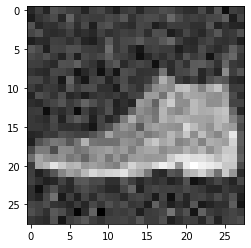

In [ ]:
noise_level = 0.1
Fashion_test_with_noise = inject_noise(FashionMNIST_test.data, noise_level)
__ = plt.imshow(Fashion_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

The function computes the representation of the noisy input data in the first, second, and third hidden layers of the DBN, and uses three separate classifiers to make predictions based on each hidden layer representation. The predictions from the FFNN on the noisy input data are also computed.The accuracy of all models on the noisy input data is calculated using a "compute_accuracy" function.

In [ ]:
#function computes the accuracy of different models on noisy test data.
def get_accuracy_values_at_noise_level(noise_level):

  # first, let's create noisy test images
  Fashion_test_with_noise = inject_noise(FashionMNIST_test.data, noise_level)  
  
  # here we compute the DBN representations
  hidden_repr_layer_1_noisy = get_kth_layer_repr(Fashion_test_with_noise, 0, device)  
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)
  
  # here we use the previously-trained read-out classifiers
  predictions_first_hidden_noisy = linear1(hidden_repr_layer_1_noisy)  
  predictions_second_hidden_noisy = linear2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear3(hidden_repr_layer_3_noisy)
  
  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, FashionMNIST_test.targets.to(device))
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, FashionMNIST_test.targets.to(device))
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, FashionMNIST_test.targets.to(device))
  
  predictions_ffnn_noisy_data = ffnn(Fashion_test_with_noise)
  accuracy_ffnn = compute_accuracy(predictions_ffnn_noisy_data, FashionMNIST_test.targets.to(device))

  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden, accuracy_ffnn

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])
    accuracy_values_ffnn.append(acc[3])

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

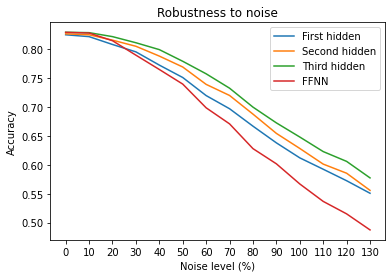

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

## Clustering internal representations

Clustering internal representations refers to the process of grouping similar internal representations (hidden activations or embeddings) of a deep learning model into clusters. The objective of clustering internal representations is to understand the underlying structure and patterns within the data that the model has learned to represent. The resulting clusters can be visualized and analyzed to gain insights into the model's behavior and interpretability. Clustering can also be used to identify and diagnose potential problems in the model's representations, such as overfitting or poor generalization.

The purpose of this code is to visualize the relationships between different classes in the neural network by clustering their mean hidden representations. The dendrogram produced by the clustering algorithm can help interpret the structure of the hidden representations.





In [ ]:
#filtering the target data based on the class
def get_mask(label): 
  labels = FashionMNIST_train.targets.cpu().numpy()
  return labels == label

#calculate the mean hidden representation of each class.
def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[get_mask(label)].mean(axis=0)  
    for label in range(10)
  }

#concatenate the mean hidden representations of each class into a matrix.
def get_hidden_reprs_matrix(hidden_representation):  
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [ ]:
#get the mean hidden representation matrix for the third hidden layer.
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In [ ]:
#imports the scipy library for clustering
import scipy.cluster as cluster

#plot the dendrogram using the complete linkage clustering method
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

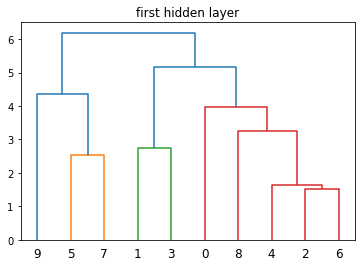

In [ ]:
#plot the dendrogram for the first hidden layer
plot_dendrogram(mean_hidd_repr_matrix_1, "first hidden layer")

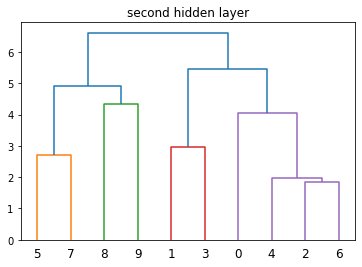

In [ ]:
#plot the dendrogram for the second hidden layer
plot_dendrogram(mean_hidd_repr_matrix_2, "second hidden layer")

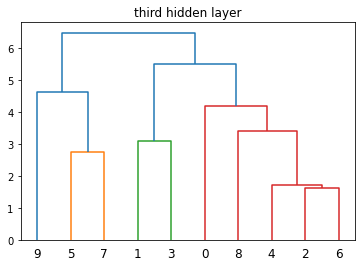

In [ ]:
#plot the dendrogram for the third hidden layer
plot_dendrogram(mean_hidd_repr_matrix_3, "third hidden layer")

##visualize confusion matrices

A confusion matrix is a table that is used to evaluate the performance of a classifier. It provides a summary of the comparison between the predicted class labels and the true class labels of instances in a dataset.

The confusion matrix is then visualized using a heatmap created with the seaborn library. The plot displays the predicted label along the x-axis and the true label along the y-axis. The cells in the heatmap are colored based on the value of each cell, with white for high values and black for low values. The code then applies the function to the FashionMNIST dataset and shows the resulting plot.

In [ ]:
from numpy.ma.core import size
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(15, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

classes = list(range(10))
y_true = FashionMNIST_test.targets.to(device).cpu().numpy()

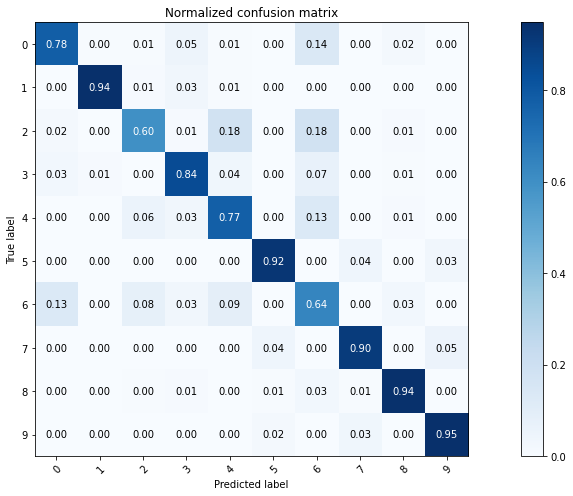

In [ ]:
#confusion matrix for ffnn 
y_pred = predictions_ffnn.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_matrix(y_true, y_pred, classes)
plt.show()

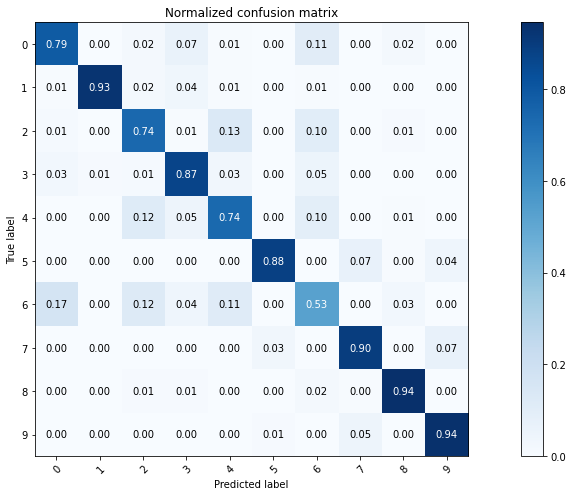

In [ ]:
#confusion matrix for the first layer of DBN
y_pred = predictions_test1.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_matrix(y_true, y_pred, classes)
plt.show()

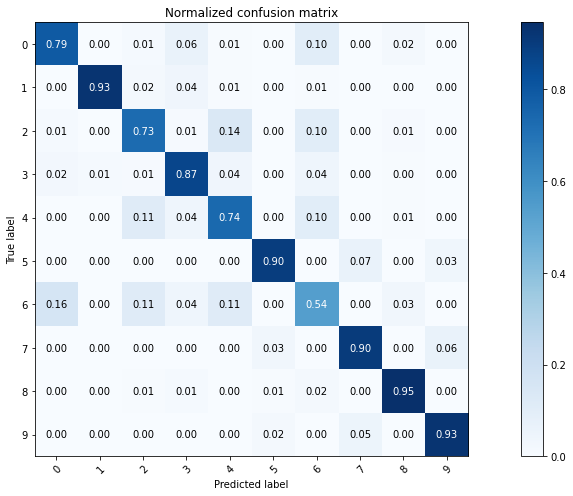

In [ ]:
#confusion matrix for the second layer of DBN
y_pred = predictions_test2.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_matrix(y_true, y_pred, classes)
plt.show()

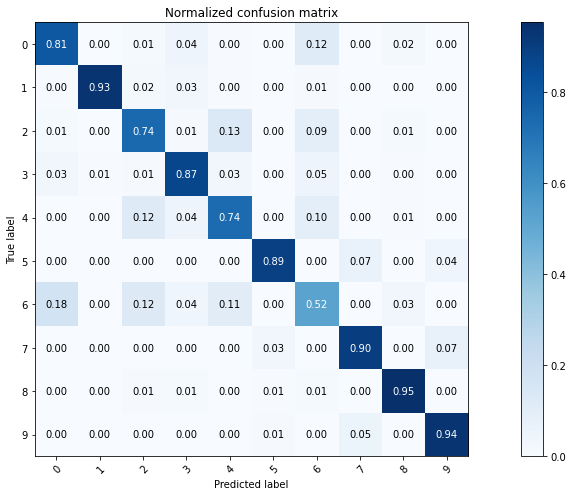

In [ ]:
#confusion matrix for the third layer of DBN
y_pred = predictions_test3.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_matrix(y_true, y_pred, classes)
plt.show()

##Evasion attack

evasion attack using FFNN model

An evasion attack, in the context of machine learning, is an attack where the attacker modifies the inputs to a model in such a way that the model's prediction changes. The goal of the attacker is to cause the model to make incorrect predictions, either by misclassifying the input or by making the model confident in an incorrect prediction.



In [ ]:
# Choose an image to attack
attacked_model = ffnn
index = 6
original_image = FashionMNIST_test.data[index].reshape((28, 28))
prediction = attacked_model(FashionMNIST_test.data[index].reshape(1, 28, 28).to(device)).cpu().detach().max(axis=1).indices.numpy()[0]
true_label = FashionMNIST_test.targets[index].numpy()


epsilon = 0.5 # magnitude of the perturbation
perturbation = np.random.rand(*original_image.shape) * 2 * epsilon - epsilon
perturbed_image = original_image + perturbation
perturbed_image = np.clip(perturbed_image, 0, 1)

# Evaluate the model on the Evasion attack
perturbed_prediction = attacked_model(perturbed_image.reshape(1, 28, 28).to(device)).cpu().detach().max(axis=1).indices.numpy()[0]

True label: 4
Prediction before attack: 4


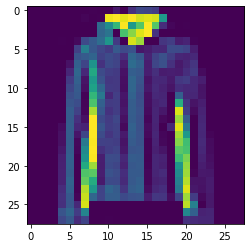

In [ ]:
print('True label:', true_label)
print('Prediction before attack:', prediction)
__ = plt.imshow(original_image)

Prediction after attack: 6


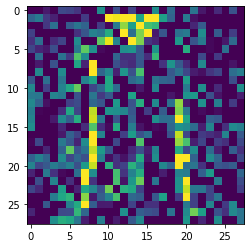

In [ ]:
print('Prediction after attack:', perturbed_prediction)
__ = plt.imshow(perturbed_image.reshape(28,28))